In [2]:
#LSTM CODE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pylab import rcParams
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

In [3]:
csv_path = "Solar_Energy1.csv"

In [4]:
dfx = pd.read_csv(csv_path)
dfx


,year,month,day,irradiation_forecast,temperature_forecast,irradiation,temperature,power
0,2017,1,1,0.000000,2.115371,0.802334,0.720098,0
1,2017,1,1,0.000000,2.185371,1.000000,1.154616,0
2,2017,1,1,0.000000,2.265371,0.891393,1.304207,0
3,2017,1,1,0.000000,2.445371,0.837256,1.079527,0
4,2017,1,1,0.000000,2.845371,0.848814,0.649967,0
...,...,...,...,...,...,...,...,...
36715,2021,3,10,19.610334,4.694629,0.770375,3.713455,0
36716,2021,3,10,0.000000,3.454629,0.987695,2.694212,0
36717,2021,3,10,0.000000,2.124629,0.987637,1.834956,0
36718,2021,3,10,0.000000,1.034629,0.993837,1.209808,0


In [5]:
dfx['time(UTC)'] = pd.to_datetime(dfx[['year','month','day']])

In [6]:
dfx.columns

Index(['year', 'month', 'day', 'irradiation_forecast', 'temperature_forecast',
       'irradiation', 'temperature', 'power', 'time(UTC)'],
      dtype='object')

In [7]:
df = dfx[['time(UTC)','irradiation']]


In [8]:
df.shape

(36720, 2)

In [9]:
df.set_index('time(UTC)', inplace = True) #UTC-Universal Time Coordinated

In [10]:
#Hours data
df


,irradiation
time(UTC),
2017-01-01,0.802334
2017-01-01,1.000000
2017-01-01,0.891393
2017-01-01,0.837256
2017-01-01,0.848814
...,...
2021-03-10,0.770375
2021-03-10,0.987695
2021-03-10,0.987637


Text(0, 0.5, '$Irradiation(W/m^2)$')

<Figure size 360x2160 with 0 Axes>

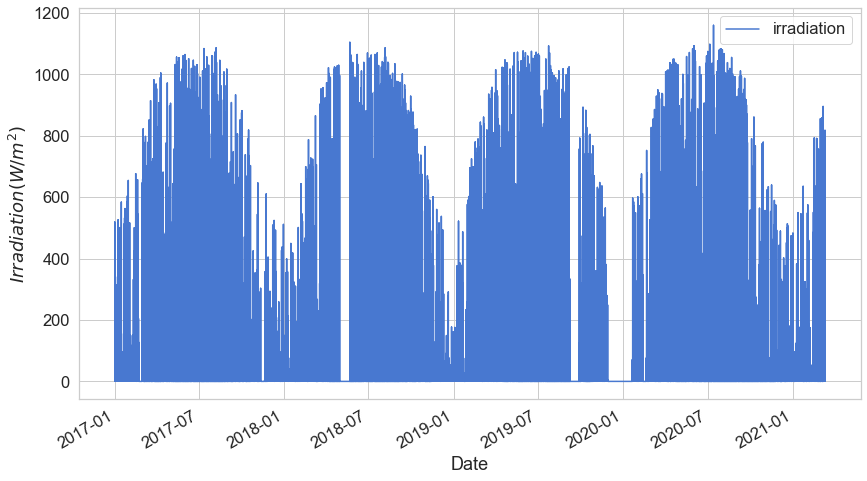

In [120]:
plt.figure(figsize=(5,30))
ax = df.plot(y='irradiation');
ax.set_xlabel("Date")
ax.set_ylabel(r'$Irradiation(W/m^2)$')

In [12]:
#Normalization

In [13]:
scaler = MinMaxScaler()

close_price = df['irradiation'].values.reshape(-1, 1)

# The scaler expects the data to be shaped as (x, y)
scaled_close = scaler.fit_transform(close_price)

In [14]:
scaled_close.shape

(36720, 1)

In [15]:
np.isnan(scaled_close).any()

False

In [16]:
scaled_close = scaled_close[~np.isnan(scaled_close)]# taking non empty values
scaled_close

array([0.0006916 , 0.00086198, 0.00076836, ..., 0.00085132, 0.00085667,
       0.00085134])

In [17]:
# reshaping data after removing NaNs
scaled_close = scaled_close.reshape(-1, 1)
scaled_close


array([[0.0006916 ],
       [0.00086198],
       [0.00076836],
       ...,
       [0.00085132],
       [0.00085667],
       [0.00085134]])

In [18]:
np.isnan(scaled_close).any()

False

In [19]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.9)

In [20]:
X_test, y_test

(array([[[6.47790762e-06],
         [1.50020261e-02],
         [6.99392081e-02],
         ...,
         [0.00000000e+00],
         [3.93854367e-04],
         [1.41154228e-02]],
 
        [[1.50020261e-02],
         [6.99392081e-02],
         [2.96568153e-01],
         ...,
         [3.93854367e-04],
         [1.41154228e-02],
         [2.53420113e-02]],
 
        [[6.99392081e-02],
         [2.96568153e-01],
         [6.01982005e-01],
         ...,
         [1.41154228e-02],
         [2.53420113e-02],
         [4.73798705e-02]],
 
        ...,
 
        [[1.20051664e-02],
         [2.36224830e-04],
         [3.34604345e-04],
         ...,
         [1.81257218e-02],
         [8.05490798e-04],
         [6.64048385e-04]],
 
        [[2.36224830e-04],
         [3.34604345e-04],
         [6.56166396e-04],
         ...,
         [8.05490798e-04],
         [6.64048385e-04],
         [8.51373860e-04]],
 
        [[3.34604345e-04],
         [6.56166396e-04],
         [8.47152000e-04],
         

In [21]:
 X_train, y_train

(array([[[6.91595881e-04],
         [8.61980161e-04],
         [7.68362984e-04],
         ...,
         [8.61914538e-04],
         [8.80793335e-04],
         [8.23789662e-04]],
 
        [[8.61980161e-04],
         [7.68362984e-04],
         [7.21698363e-04],
         ...,
         [8.80793335e-04],
         [8.23789662e-04],
         [8.49114453e-04]],
 
        [[7.68362984e-04],
         [7.21698363e-04],
         [7.31660651e-04],
         ...,
         [8.23789662e-04],
         [8.49114453e-04],
         [8.49587100e-04]],
 
        ...,
 
        [[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00]],
 
        [[0.00000000e+00],
         [0.00000000e+00],
         [6.47790762e-06],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00]],
 
        [[0.00000000e+00],
         [6.47790762e-06],
         [1.50020261e-02],
         

In [22]:
df.shape

(36720, 1)

In [23]:
X_train.shape

(32958, 99, 1)

In [24]:
X_test.shape

(3662, 99, 1)

In [25]:
#Model

In [26]:
model = tf.keras.Sequential()
# adding 1st LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
# adding 2nd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 3rd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 4th LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
# adding output layer
model.add(tf.keras.layers.Dense(units=1))
#compiling RNN
#model.compile(loss='mean_squared_error', optimizer='adam')
#early_stopping = EarlyStopping(monitor='loss', patience=10)
# fitting RNN on training set
#model.fit(X_train, y_train, epochs= 100, batch_size=32, 
          #verbose=2, callbacks=[early_stopping])
#model.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=2)

In [27]:
model.compile(
    loss='mean_squared_error', metrics=['accuracy'],
    optimizer='adam'
)

In [270]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 99, 50)            10400     
_________________________________________________________________
dropout_24 (Dropout)         (None, 99, 50)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 99, 50)            20200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 99, 50)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 99, 50)            20200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 99, 50)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 50)               

In [271]:
BATCH_SIZE = 60
# History attribute is a record of training loss values at successive epochs, as well as validation loss values
history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
495/495 [==============================] - 71s 133ms/step - loss: 0.0218 - accuracy: 0.1129 - val_loss: 0.0223 - val_accuracy: 0.2285
Epoch 2/100
495/495 [==============================] - 66s 134ms/step - loss: 0.0150 - accuracy: 0.1129 - val_loss: 0.0153 - val_accuracy: 0.2282
Epoch 3/100
495/495 [==============================] - 72s 145ms/step - loss: 0.0110 - accuracy: 0.1130 - val_loss: 0.0125 - val_accuracy: 0.2282
Epoch 4/100
495/495 [==============================] - 64s 128ms/step - loss: 0.0087 - accuracy: 0.1130 - val_loss: 0.0098 - val_accuracy: 0.2285
Epoch 5/100
495/495 [==============================] - 63s 127ms/step - loss: 0.0067 - accuracy: 0.1130 - val_loss: 0.0077 - val_accuracy: 0.2285
Epoch 6/100
495/495 [==============================] - 63s 127ms/step - loss: 0.0057 - accuracy: 0.1130 - val_loss: 0.0072 - val_accuracy: 0.2285
Epoch 7/100
495/495 [==============================] - 63s 127ms/step - loss: 0.0052 - accuracy: 0.1130 - val_loss: 0.0061 -

In [272]:
model.save('my_model_D.h5')  # creates a HDF5 file 'my_model.h5'

In [273]:
model = keras.models.load_model('my_model_D.h5')

In [274]:
model.evaluate(X_test, y_test)

115/115 [==============================] - 11s 33ms/step - loss: 0.0039 - accuracy: 0.0953


[0.003886500373482704, 0.09530311077833176]

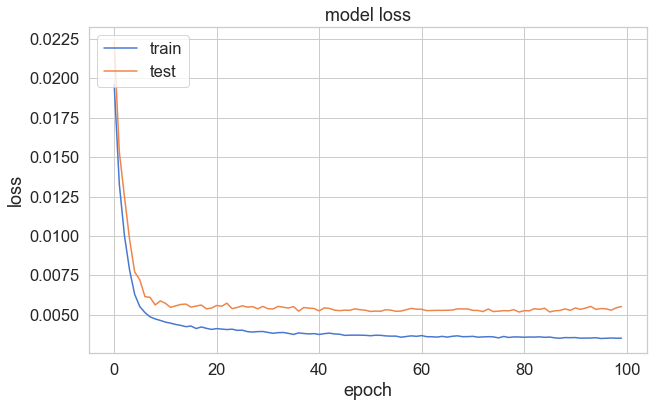

In [275]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

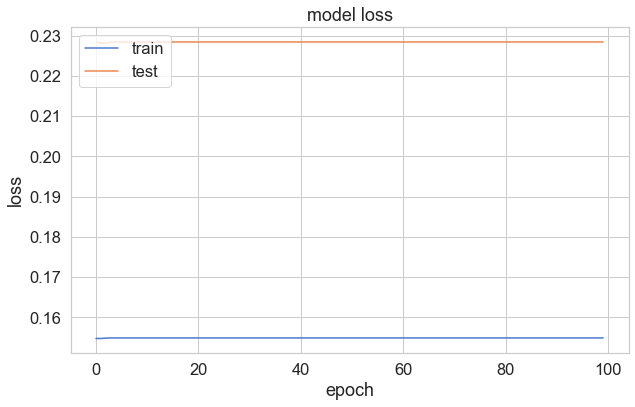

In [276]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

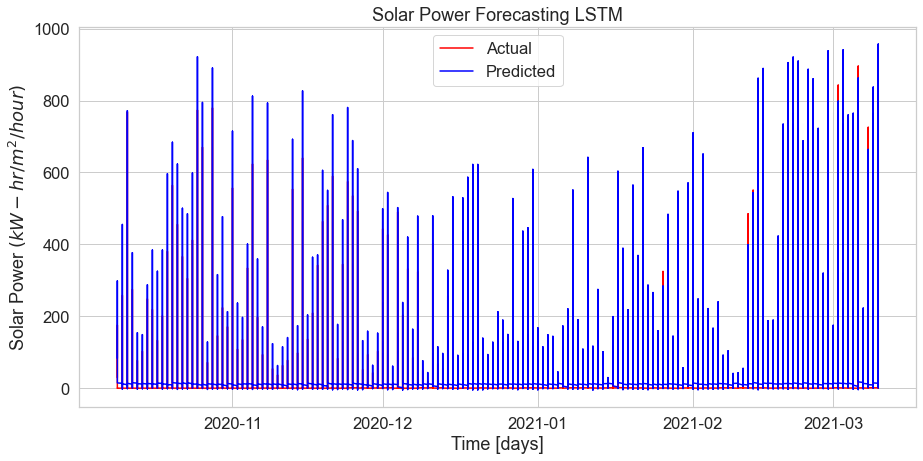

In [277]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.figure(figsize=(15,7))
plt.plot(df.index[-len(X_test):],y_test_inverse, label="Actual", color='red')
plt.plot(df.index[-len(X_test):],y_hat_inverse, label="Predicted", color='blue')

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [hours]')
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

In [278]:
from sklearn.metrics import r2_score

r2_score(y_test_inverse,y_hat_inverse)

0.739329749370095

In [279]:
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(y_test_inverse, y_hat_inverse, squared=False)
RMSE
# from sklearn import metrics
# from math import sqrt

# rmse = sqrt(mean_squared_error(y_test_inverse, y_hat_inverse))
# rmse

72.32393792650188

In [281]:
 from sklearn import metrics
 from math import sqrt
y_train_pred = model.predict(X_train)
rmse = sqrt(metrics.mean_squared_error(y_train, y_train_pred) )
rmse

0.06648876020293089

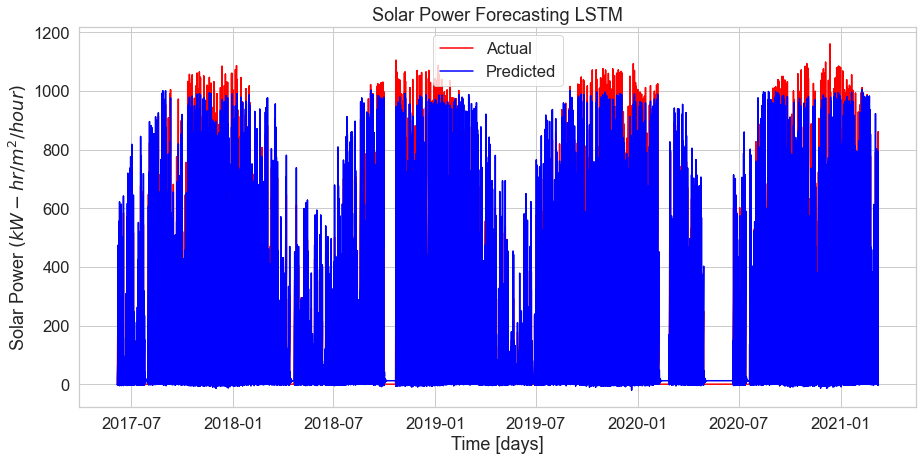

In [282]:
y_hat1 = model.predict(X_train)

y_train_inverse1 = scaler.inverse_transform(y_train)
y_hat_inverse1 = scaler.inverse_transform(y_hat1)

plt.figure(figsize=(15,7))
plt.plot(df.index[-len(X_train):],y_train_inverse1, label="Actual", color='red')
plt.plot(df.index[-len(X_train):],y_hat_inverse1, label="Predicted", color='blue')

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [hours]')
plt.ylabel(r'Solar Irradiation $(W-/m^2)$')
plt.legend(loc='best')
 
plt.show();

In [283]:
RMSE = mean_squared_error(y_train_inverse1, y_hat_inverse1, squared=False)
RMSE

77.13490754018605

In [121]:
#Days

In [135]:
df3 = df.copy()

In [136]:
df3

,irradiation
time(UTC),
2017-01-01,0.802334
2017-01-01,1.000000
2017-01-01,0.891393
2017-01-01,0.837256
2017-01-01,0.848814
...,...
2021-03-10,0.770375
2021-03-10,0.987695
2021-03-10,0.987637


In [137]:
df3.resample('D', label='left')

In [138]:
opsd_Day_mean = df3['irradiation'].resample('D').mean()

In [139]:
opsd_Day_mean.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04',
               '2021-03-05', '2021-03-06', '2021-03-07', '2021-03-08',
               '2021-03-09', '2021-03-10'],
              dtype='datetime64[ns]', name='time(UTC)', length=1530, freq='D')

In [140]:
df_d = pd.DataFrame(data=opsd_Day_mean, index=opsd_Day_mean.index)

In [141]:
df_d['time(UTC)']=opsd_Day_mean.index
df_d.reset_index(drop=True, inplace=True)
df_d

,irradiation,time(UTC)
0,98.824703,2017-01-01
1,7.734570,2017-01-02
2,9.191607,2017-01-03
3,23.175814,2017-01-04
4,61.680674,2017-01-05
...,...,...
1525,213.458885,2021-03-06
1526,37.296009,2021-03-07
1527,151.429172,2021-03-08
1528,166.981803,2021-03-09


Text(0, 0.5, '$Irradiation (W/m^2)$')

<Figure size 360x2160 with 0 Axes>

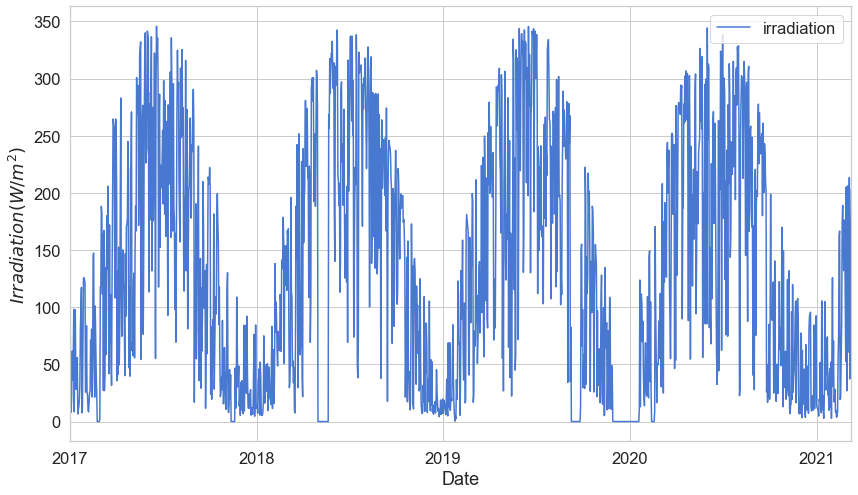

In [142]:
plt.figure(figsize=(5,30))
ax = df_d.plot(x='time(UTC)', y='irradiation');
ax.set_xlabel("Date")
ax.set_ylabel(r'$Irradiation (W/m^2)$')

Text(0.5, 0, '$Irradiation (W/m^2)$')

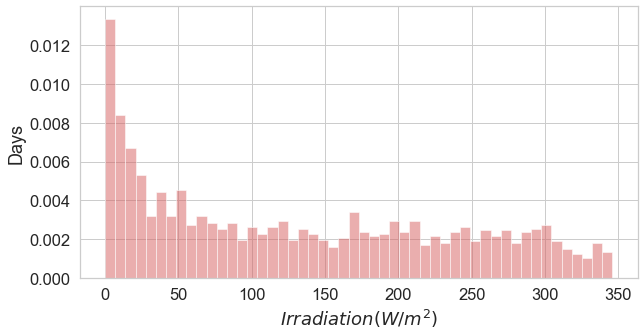

In [143]:
plt.figure(figsize=(10,5))
plt.hist(df_d['irradiation'], bins=50, density=True, facecolor='r', alpha=0.5);
plt.ylabel(r"Days")
plt.xlabel(r'$Irradiation (W/m^2)$')

In [144]:
#Normalization

In [145]:
scaler = MinMaxScaler()

close_price = df_d['irradiation'].values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [146]:
scaled_close.shape

(1530, 1)

In [147]:
np.isnan(scaled_close).any()

False

In [148]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [149]:
scaled_close = scaled_close.reshape(-1, 1)

In [150]:
np.isnan(scaled_close).any()

False

In [151]:
#Preprocessing

In [152]:
SEQ_LEN = 60

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.9)

In [153]:
df_d.shape

(1530, 2)

In [154]:
X_train.shape

(1323, 59, 1)

In [155]:
X_test.shape

(147, 59, 1)

In [156]:
#Model

In [157]:
model = tf.keras.Sequential()
# adding 1st LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
# adding 2nd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 3rd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 4th LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
# adding output layer
model.add(tf.keras.layers.Dense(units=1))
#compiling RNN
#model.compile(loss='mean_squared_error', optimizer='adam')
#early_stopping = EarlyStopping(monitor='loss', patience=10)
# fitting RNN on training set
#model.fit(X_train, y_train, epochs= 100, batch_size=32, 
          #verbose=2, callbacks=[early_stopping])
#model.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=2)

In [158]:
model.compile(
    loss='mean_squared_error', metrics=['accuracy'],
    optimizer='adam'
)

In [159]:
BATCH_SIZE = 60

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
20/20 [==============================] - 8s 134ms/step - loss: 0.1747 - accuracy: 0.0345 - val_loss: 0.0910 - val_accuracy: 0.0000e+00
Epoch 2/100
20/20 [==============================] - 1s 75ms/step - loss: 0.0673 - accuracy: 0.0267 - val_loss: 0.0740 - val_accuracy: 0.0000e+00
Epoch 3/100
20/20 [==============================] - 1s 75ms/step - loss: 0.0606 - accuracy: 0.0302 - val_loss: 0.0696 - val_accuracy: 0.0000e+00
Epoch 4/100
20/20 [==============================] - 1s 76ms/step - loss: 0.0600 - accuracy: 0.0314 - val_loss: 0.0701 - val_accuracy: 0.0000e+00
Epoch 5/100
20/20 [==============================] - 2s 76ms/step - loss: 0.0560 - accuracy: 0.0338 - val_loss: 0.0695 - val_accuracy: 0.0000e+00
Epoch 6/100
20/20 [==============================] - 2s 78ms/step - loss: 0.0550 - accuracy: 0.0331 - val_loss: 0.0693 - val_accuracy: 0.0000e+00
Epoch 7/100
20/20 [==============================] - 2s 75ms/step - loss: 0.0543 - accuracy: 0.0331 - val_loss: 0.0686 - va

In [160]:
model.save('my_model_W.h5')  # creates a HDF5 file 'my_model.h5'

In [161]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 15ms/step - loss: 0.0185 - accuracy: 0.0000e+00


[0.018541041761636734, 0.0]

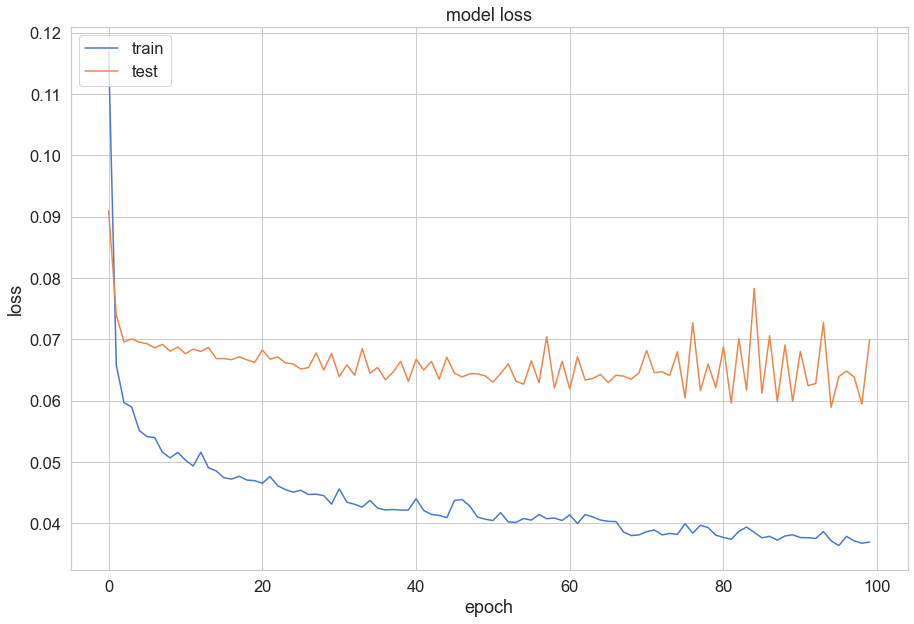

In [162]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

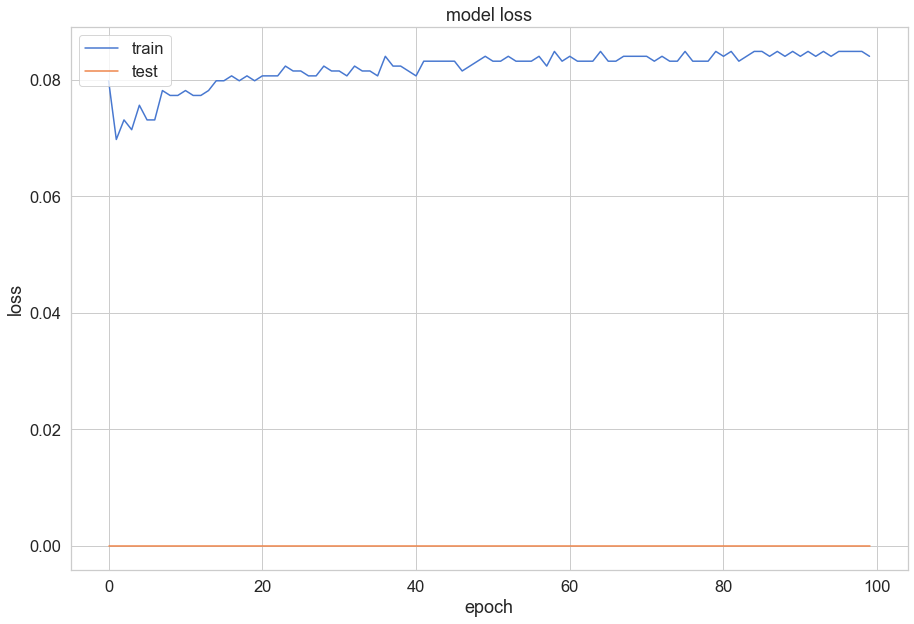

In [163]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [164]:
#Prediction

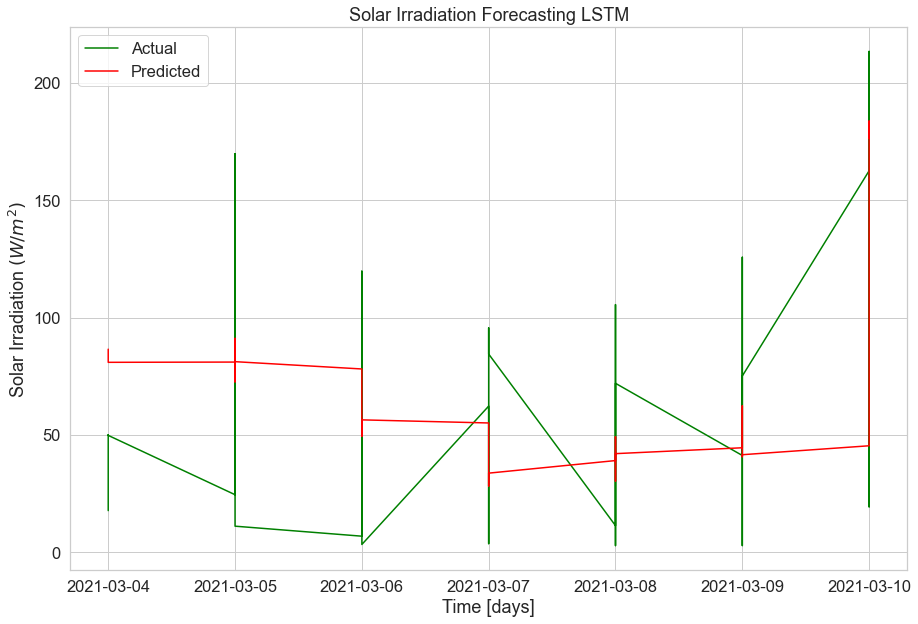

In [165]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(df3.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df3.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')
#
plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

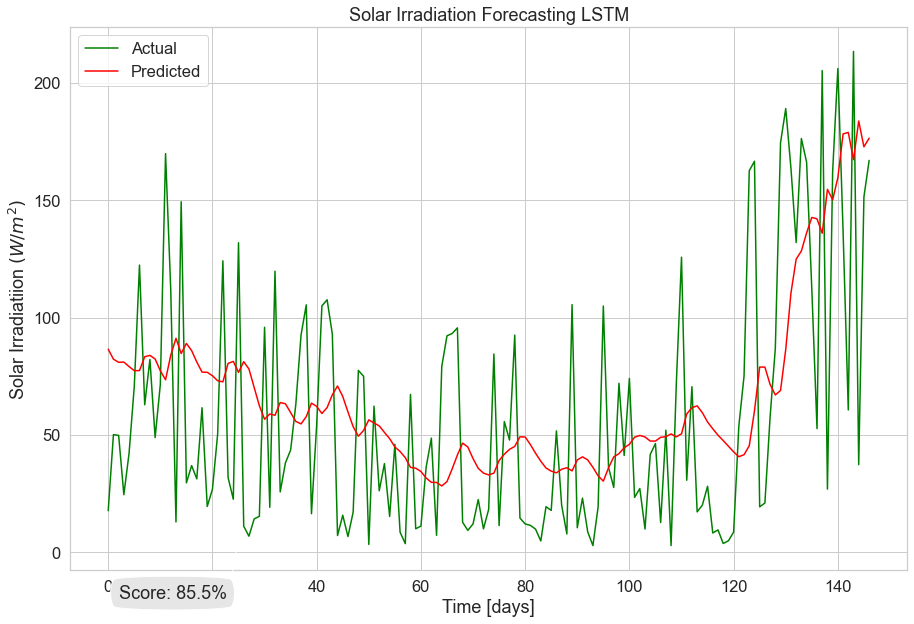

In [167]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(y_test_inverse, label="Actual", color='green')
plt.plot(y_hat_inverse, label="Predicted", color='red')
#
plt.annotate('Score: 85.5%', xy=(25, 6),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Irradiatiion $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

In [168]:
from sklearn.metrics import r2_score

r2_score(y_test_inverse,y_hat_inverse)

0.1960207279126126

In [169]:
rmse = mean_squared_error(y_test_inverse,y_hat_inverse, squared=False)
rmse

47.093533203542286

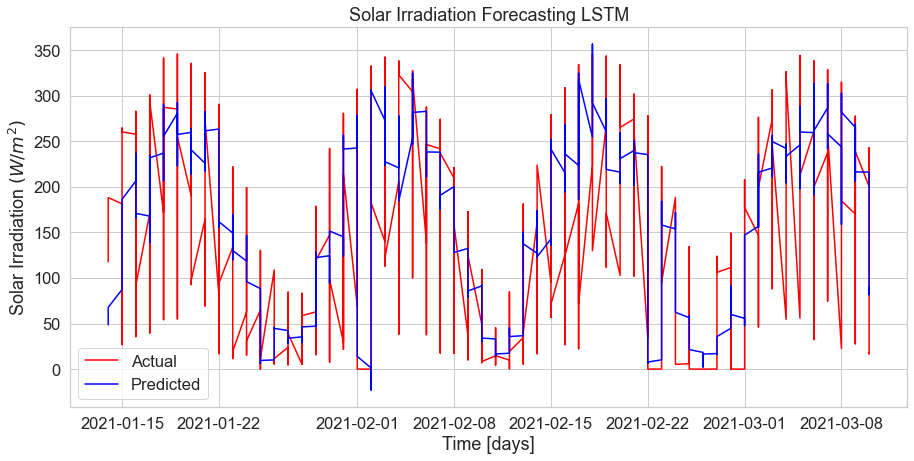

In [170]:
y_hat1 = model.predict(X_train)

y_train_inverse1 = scaler.inverse_transform(y_train)
y_hat_inverse1 = scaler.inverse_transform(y_hat1)

plt.figure(figsize=(15,7))
plt.plot(df3.index[-len(X_train):],y_train_inverse1, label="Actual", color='red')
plt.plot(df3.index[-len(X_train):],y_hat_inverse1, label="Predicted", color='blue')

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

In [171]:
RMSE = mean_squared_error(y_train_inverse1, y_hat_inverse1, squared=False)
RMSE

69.99826946185954

In [172]:
#Prediction_with_error

In [173]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    #ax.plot(x, y, color=color, label="Predicted")
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

In [174]:
L=len(y_hat_inverse)
x = np.linspace(0, L,L)

In [175]:
y_hat_inverse[:,0].std()

35.033825

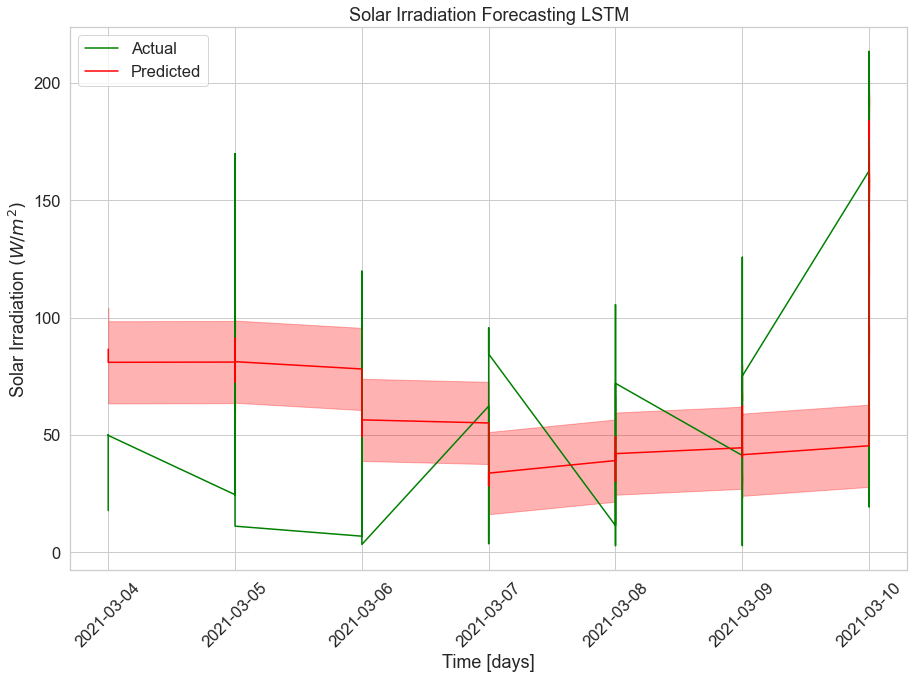

In [177]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(df3.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df3.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')
errorfill(df3.index[-len(X_test):],y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')
#

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [days]')
plt.xticks(rotation=45)
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

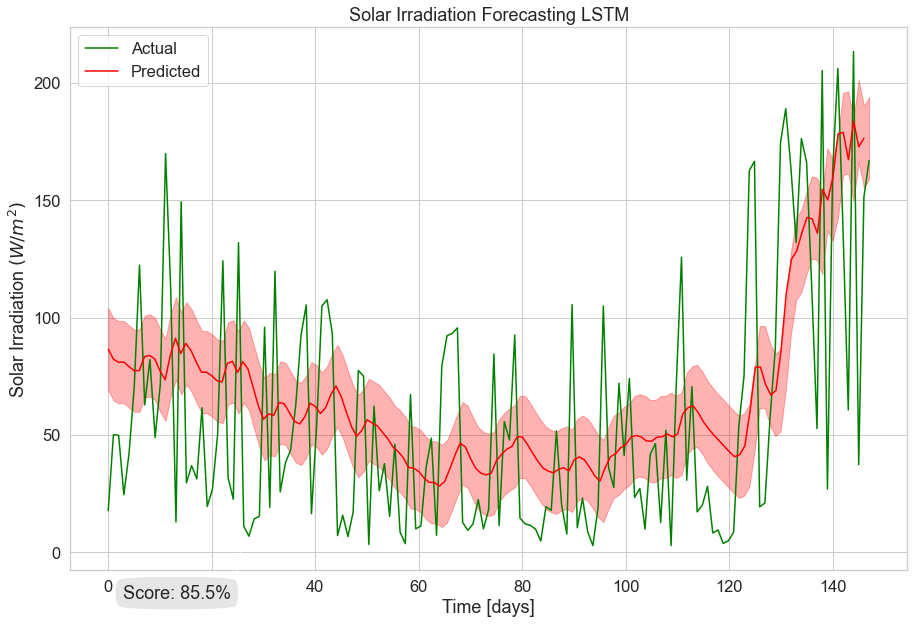

In [178]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(x,y_test_inverse, label="Actual", color='green')
plt.plot(y_hat_inverse, label="Predicted", color='red')
errorfill(x,y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')
#
plt.annotate('Score: 85.5%', xy=(26, 6),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

In [28]:
# Week data

In [29]:
df1 = df.copy()

In [30]:
df1

,irradiation
time(UTC),
2017-01-01,0.802334
2017-01-01,1.000000
2017-01-01,0.891393
2017-01-01,0.837256
2017-01-01,0.848814
...,...
2021-03-10,0.770375
2021-03-10,0.987695
2021-03-10,0.987637


In [31]:
df1.resample('W', label='left')

In [32]:
opsd_weekly_mean = df1['irradiation'].resample('W').mean()

In [33]:
opsd_weekly_mean.index

DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05',
               ...
               '2021-01-10', '2021-01-17', '2021-01-24', '2021-01-31',
               '2021-02-07', '2021-02-14', '2021-02-21', '2021-02-28',
               '2021-03-07', '2021-03-14'],
              dtype='datetime64[ns]', name='time(UTC)', length=220, freq='W-SUN')

In [34]:
df_w = pd.DataFrame(data=opsd_weekly_mean, index=opsd_weekly_mean.index)

In [35]:
df_w['time(UTC)']=opsd_weekly_mean.index
df_w.reset_index(drop=True, inplace=True)
df_w

,irradiation,time(UTC)
0,98.824703,2017-01-01
1,41.115110,2017-01-08
2,48.468265,2017-01-15
3,37.737983,2017-01-22
4,83.020672,2017-01-29
...,...,...
215,45.429489,2021-02-14
216,102.149481,2021-02-21
217,144.057295,2021-02-28
218,120.496597,2021-03-07


Text(0, 0.5, '$Irradiation (W/m^2)$')

<Figure size 360x2160 with 0 Axes>

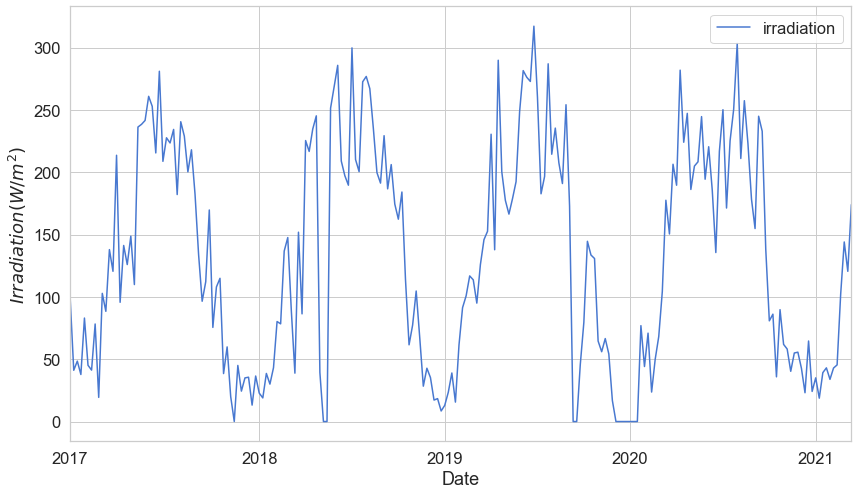

In [180]:
plt.figure(figsize=(5,30))
ax = df_w.plot(x='time(UTC)', y='irradiation');
ax.set_xlabel("Date")
ax.set_ylabel(r'$Irradiation (W/m^2)$')

Text(0.5, 0, '$Irradiation (W/m^2)$')

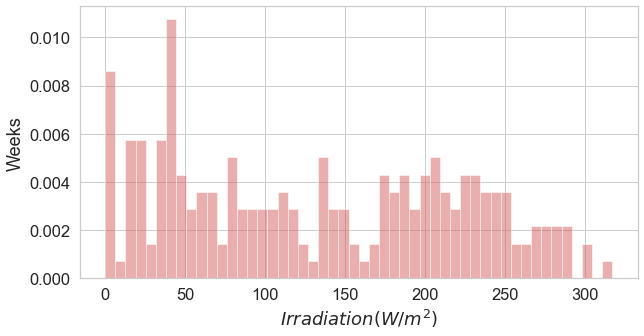

In [187]:
plt.figure(figsize=(10,5))
plt.hist(df_w['irradiation'], bins=50, density=True, facecolor='r', alpha=0.5);
plt.ylabel(r"Weeks")
plt.xlabel(r'$Irradiation (W/m^2)$')

In [188]:
#Normalization

In [189]:
scaler = MinMaxScaler()

close_price = df_w['irradiation'].values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [190]:
scaled_close.shape

(220, 1)

In [191]:
np.isnan(scaled_close).any()

False

In [192]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [193]:
scaled_close = scaled_close.reshape(-1, 1)

In [194]:
np.isnan(scaled_close).any()

False

In [195]:
#Preprocessing

In [196]:
SEQ_LEN = 15

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.9)

In [197]:
df_w.shape

(220, 2)

In [198]:
X_train.shape

(184, 14, 1)

In [199]:
X_test.shape

(21, 14, 1)

In [200]:
model = tf.keras.Sequential()
# adding 1st LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
# adding 2nd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 3rd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 4th LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
# adding output layer
model.add(tf.keras.layers.Dense(units=1))
#compiling RNN
model.compile(loss='mean_squared_error', optimizer='adam')
#early_stopping = EarlyStopping(monitor='loss', patience=10)
# fitting RNN on training set
#model.fit(X_train, y_train, epochs= 100, batch_size=32, 
          #verbose=2, callbacks=[early_stopping])
#model.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=2)

In [201]:
model.compile(
    loss='mean_squared_error', metrics=['accuracy'],
    optimizer='adam'
)

In [202]:
BATCH_SIZE = 60

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
3/3 [==============================] - 8s 796ms/step - loss: 0.2462 - accuracy: 0.0428 - val_loss: 0.2778 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 35ms/step - loss: 0.1681 - accuracy: 0.0428 - val_loss: 0.1208 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0926 - accuracy: 0.0398 - val_loss: 0.0376 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 33ms/step - loss: 0.0904 - accuracy: 0.0328 - val_loss: 0.0365 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0864 - accuracy: 0.0263 - val_loss: 0.0542 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 33ms/step - loss: 0.0789 - accuracy: 0.0428 - val_loss: 0.0841 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 39ms/step - loss: 0.0840 - accuracy: 0.0428 - val_loss: 0.0877 - val_accuracy: 0.

In [203]:
model.save('my_model_W.h5')  # creates a HDF5 file 'my_model.h5'

In [204]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 17ms/step - loss: 0.0140 - accuracy: 0.0000e+00


[0.014043041504919529, 0.0]

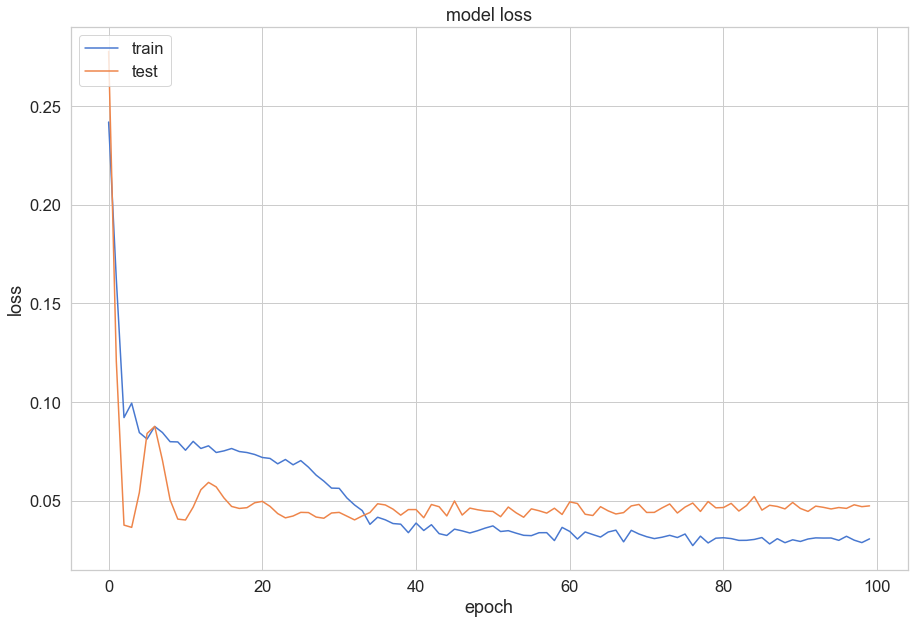

In [205]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

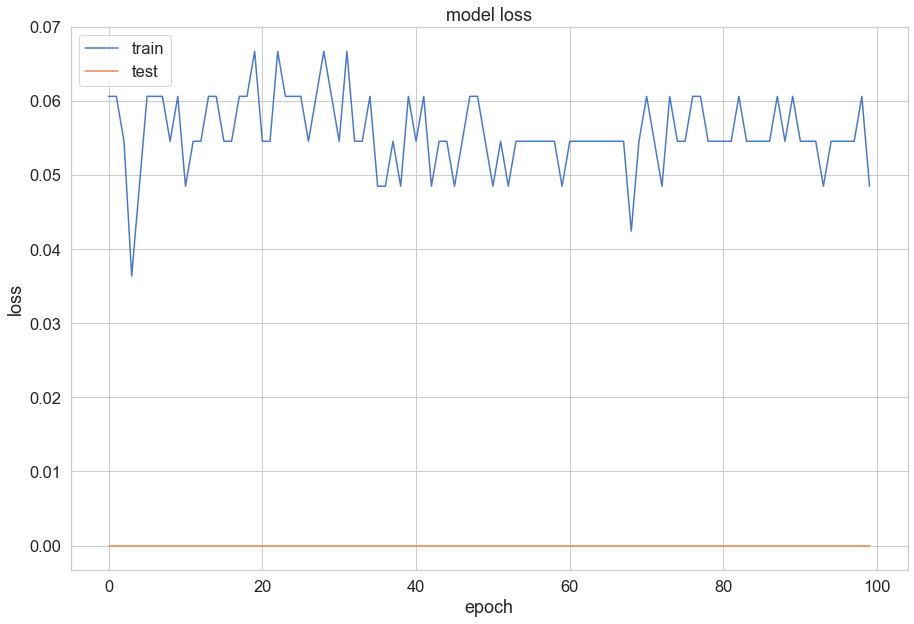

In [206]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [207]:
#Prediction

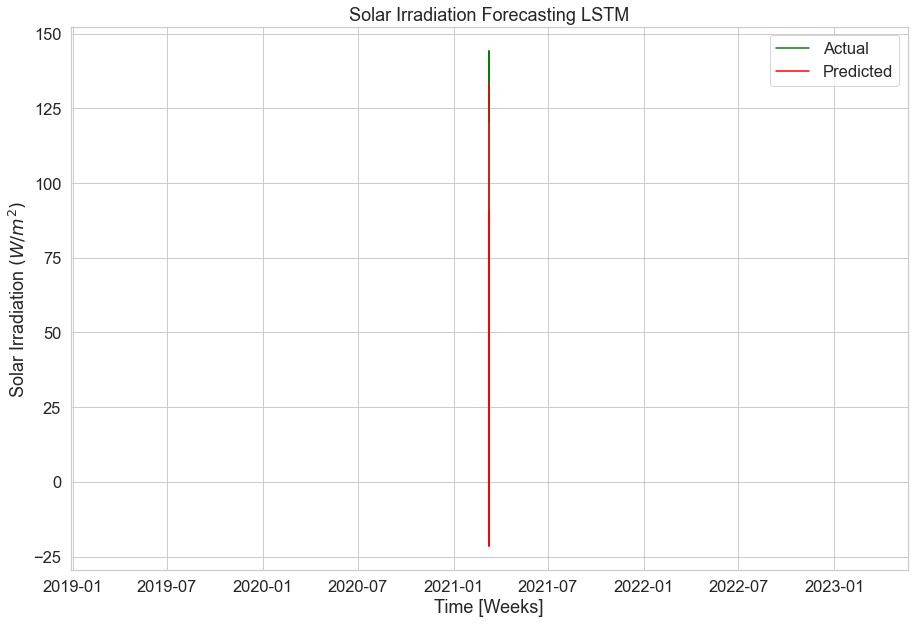

In [209]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(df1.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df1.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')
#
plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [Weeks]')
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

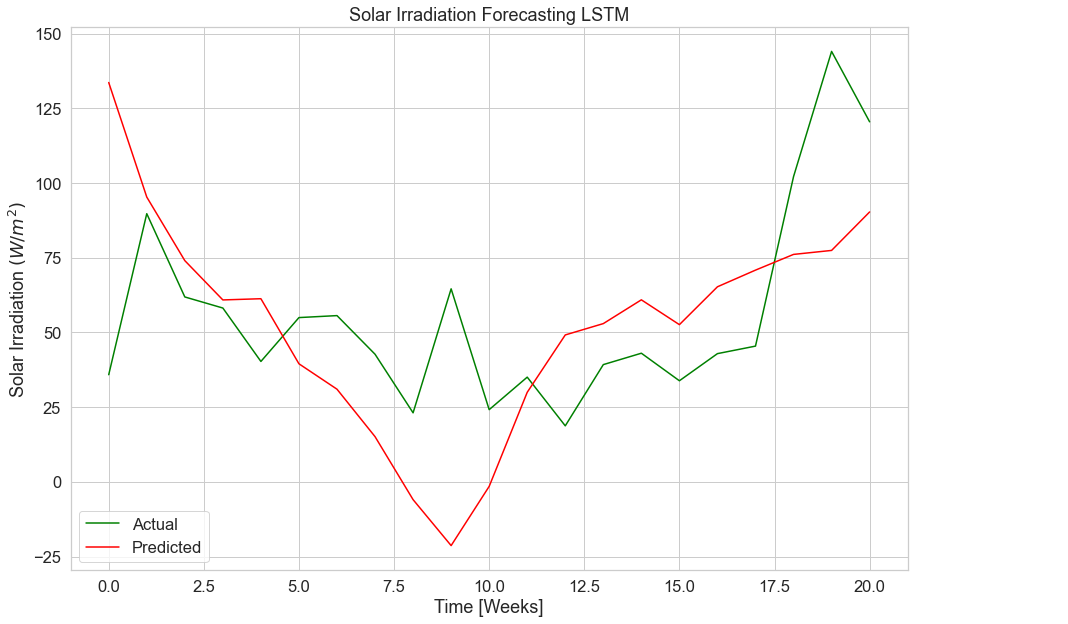

In [210]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(y_test_inverse, label="Actual", color='green')
plt.plot(y_hat_inverse, label="Predicted", color='red')
#
plt.annotate('Score: 85.5%', xy=(25, 6),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [Weeks]')
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

In [211]:
from sklearn.metrics import r2_score

r2_score(y_test_inverse,y_hat_inverse)

-0.3945763362755499

In [212]:
rmse = mean_squared_error(y_test_inverse,y_hat_inverse, squared=False)
rmse

37.5850581516741

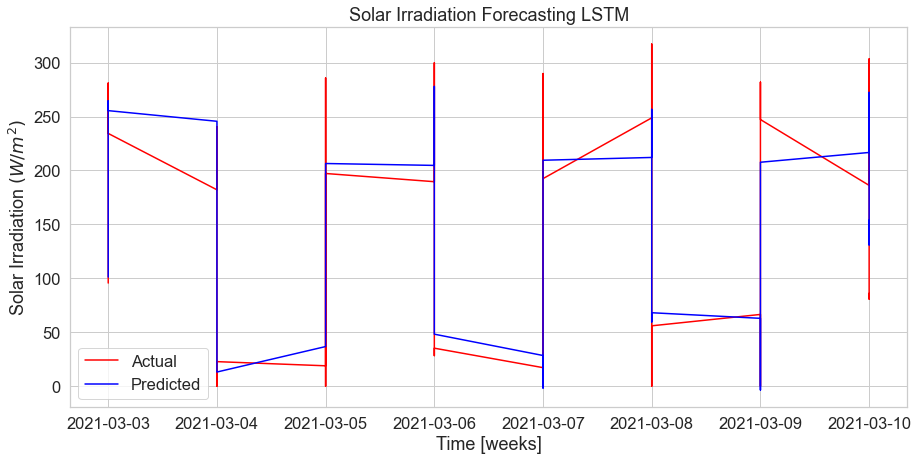

In [221]:
y_hat1 = model.predict(X_train)

y_train_inverse1 = scaler.inverse_transform(y_train)
y_hat_inverse1 = scaler.inverse_transform(y_hat1)

plt.figure(figsize=(15,7))
plt.plot(df.index[-len(X_train):],y_train_inverse1, label="Actual", color='red')
plt.plot(df.index[-len(X_train):],y_hat_inverse1, label="Predicted", color='blue')

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [weeks]')
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

In [222]:
RMSE = mean_squared_error(y_train_inverse1, y_hat_inverse1, squared=False)
RMSE

52.79019209392316

In [223]:
#Prediction_with_error

In [224]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    #ax.plot(x, y, color=color, label="Predicted")
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

In [225]:
L=len(y_hat_inverse)
x = np.linspace(0, L,L)

In [226]:
y_hat_inverse[:,0].std()

35.55163

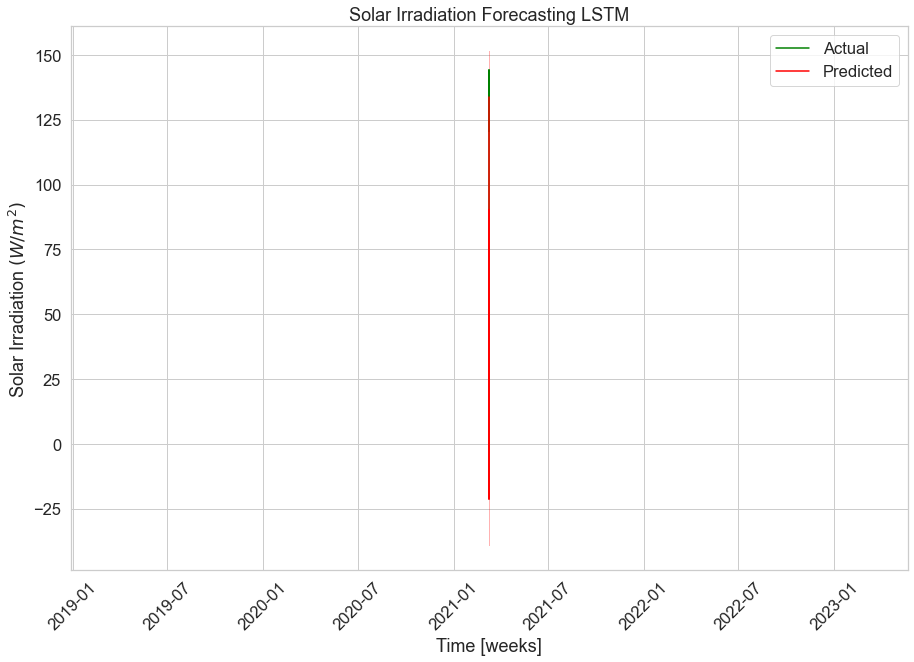

In [227]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(df1.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df1.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')
errorfill(df1.index[-len(X_test):],y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')
#

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [weeks]')
plt.xticks(rotation=45)
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

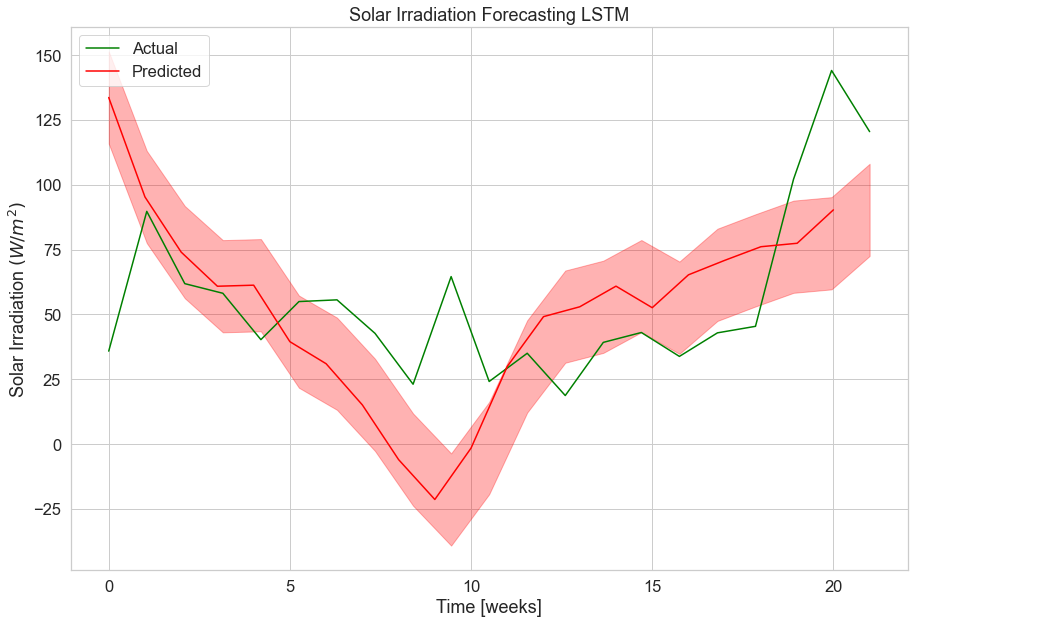

In [228]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(x,y_test_inverse, label="Actual", color='green')
plt.plot(y_hat_inverse, label="Predicted", color='red')
errorfill(x,y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')
#
plt.annotate('Score: 85.5%', xy=(26, 6),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [weeks]')
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

In [229]:
#Months

In [230]:
df2 = df.copy()

In [231]:
df2.resample('M', label='left')

In [232]:
opsd_month_mean = df2['irradiation'].resample('M').mean()

In [233]:
opsd_month_mean.index

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31'],
              dtype='datetime64[ns]', name='time(UTC)', freq='M')

In [234]:
df_m = pd.DataFrame(data=opsd_month_mean, index=opsd_month_mean.index)

In [235]:
df_m['time(UTC)']=opsd_month_mean.index
df_m.reset_index(drop=True, inplace=True)
df_m

,irradiation,time(UTC)
0,55.415484,2017-01-31
1,40.837291,2017-02-28
2,135.065180,2017-03-31
3,134.488075,2017-04-30
4,209.077359,2017-05-31
5,246.318754,2017-06-30
6,219.400428,2017-07-31
7,225.690481,2017-08-31
8,119.180937,2017-09-30
9,86.575660,2017-10-31


Text(0, 0.5, 'Irradiation (W/m^2)$')

<Figure size 360x2160 with 0 Axes>

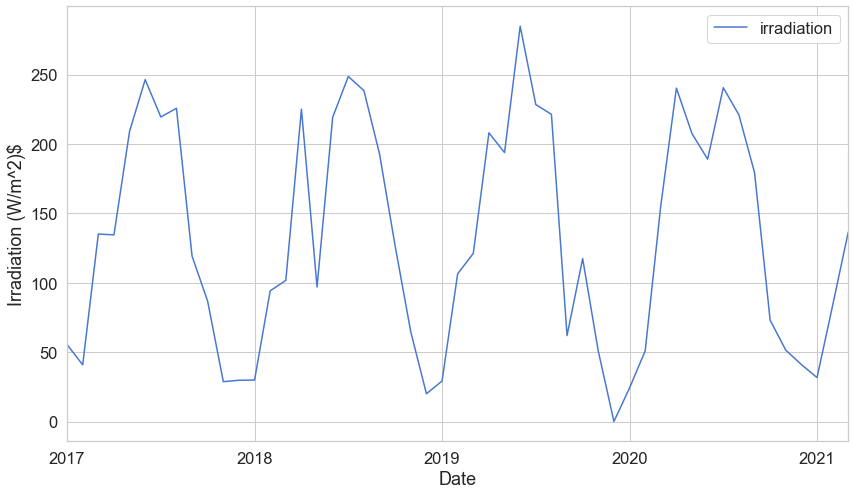

In [277]:
plt.figure(figsize=(5,30))
ax = df_m.plot(x='time(UTC)', y='irradiation');
ax.set_xlabel("Date")
ax.set_ylabel(r'Irradiation (W/m^2)$')

Text(0.5, 0, '$Irradiation (W/m^2)$')

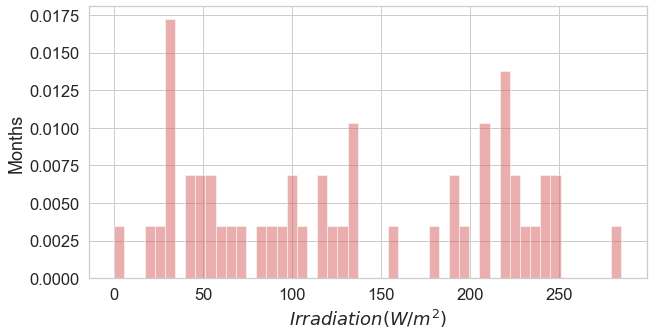

In [278]:
plt.figure(figsize=(10,5))
plt.hist(df_m['irradiation'], bins=50, density=True, facecolor='r', alpha=0.5);
plt.ylabel(r"Months")
plt.xlabel(r'$Irradiation (W/m^2)$')

In [240]:
#Normalization

In [241]:
scaler = MinMaxScaler()

close_price = df_m['irradiation'].values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [242]:
scaled_close.shape

(51, 1)

In [243]:
np.isnan(scaled_close).any()

False

In [244]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [245]:
scaled_close = scaled_close.reshape(-1, 1)

In [246]:
np.isnan(scaled_close).any()

False

In [247]:
#Preprocessing

In [248]:
SEQ_LEN = 10

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.85)

In [249]:
df_m.shape


(51, 2)

In [250]:
X_train.shape

(34, 9, 1)

In [251]:
X_test.shape

(7, 9, 1)

In [252]:
#Model

In [253]:
model = tf.keras.Sequential()
# adding 1st LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
# adding 2nd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 3rd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 4th LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
# adding output layer
model.add(tf.keras.layers.Dense(units=1))
#compiling RNN
model.compile(loss='mean_squared_error', optimizer='adam')
#early_stopping = EarlyStopping(monitor='loss', patience=10)
# fitting RNN on training set
#model.fit(X_train, y_train, epochs= 100, batch_size=32, 
          #verbose=2, callbacks=[early_stopping])
#model.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=2)

In [254]:
model.compile(
    loss='mean_squared_error', metrics=['accuracy'],
    optimizer='adam'
)

In [255]:
BATCH_SIZE = 60

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 0.2707 - accuracy: 0.0333 - val_loss: 0.5745 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 53ms/step - loss: 0.2542 - accuracy: 0.0333 - val_loss: 0.5465 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 56ms/step - loss: 0.2386 - accuracy: 0.0333 - val_loss: 0.5163 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 48ms/step - loss: 0.2234 - accuracy: 0.0333 - val_loss: 0.4831 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 49ms/step - loss: 0.2057 - accuracy: 0.0333 - val_loss: 0.4459 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 55ms/step - loss: 0.1857 - accuracy: 0.0333 - val_loss: 0.4040 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: 0.1688 - accuracy: 0.0333 - val_loss: 0.3570 - val_accuracy: 0.000

In [256]:
model.save('my_model_M.h5')  # creates a HDF5 file 'my_model.h5'

In [257]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 0.0000e+00


[0.0024652741849422455, 0.0]

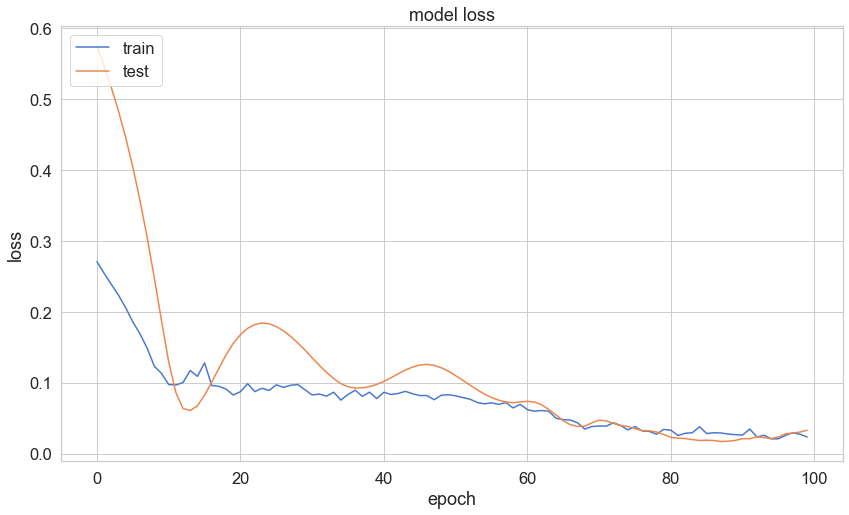

In [258]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

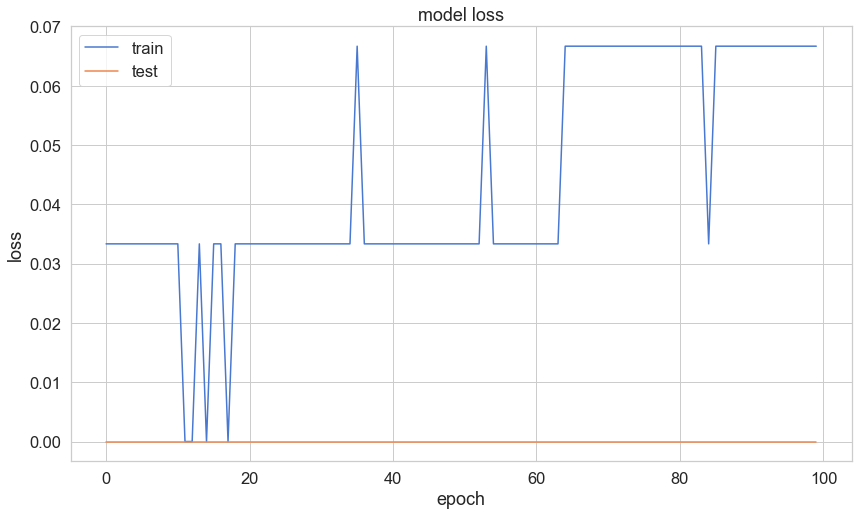

In [259]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

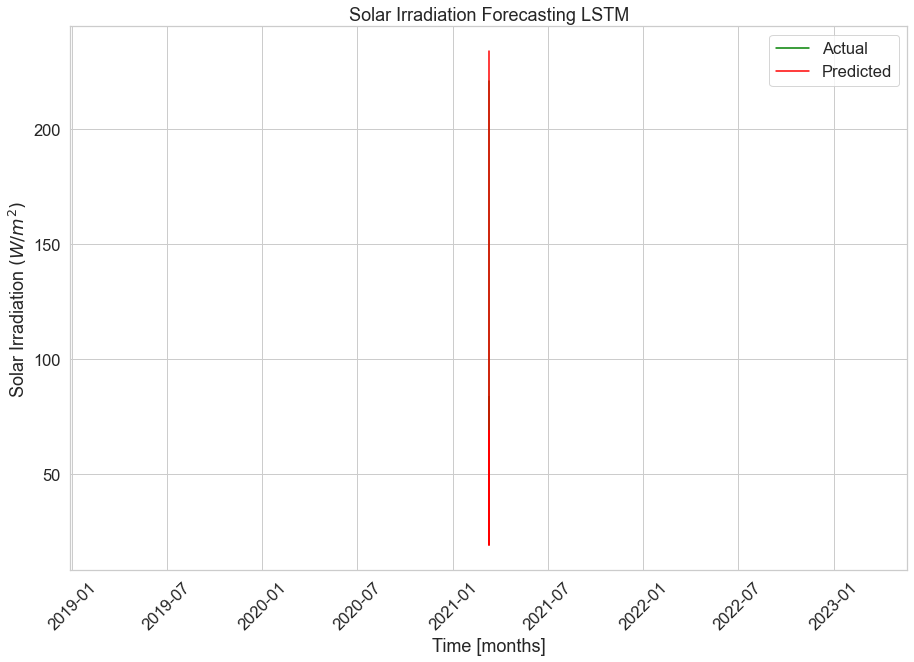

In [276]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(df2.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df2.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [months]')
plt.xticks(rotation=45)
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

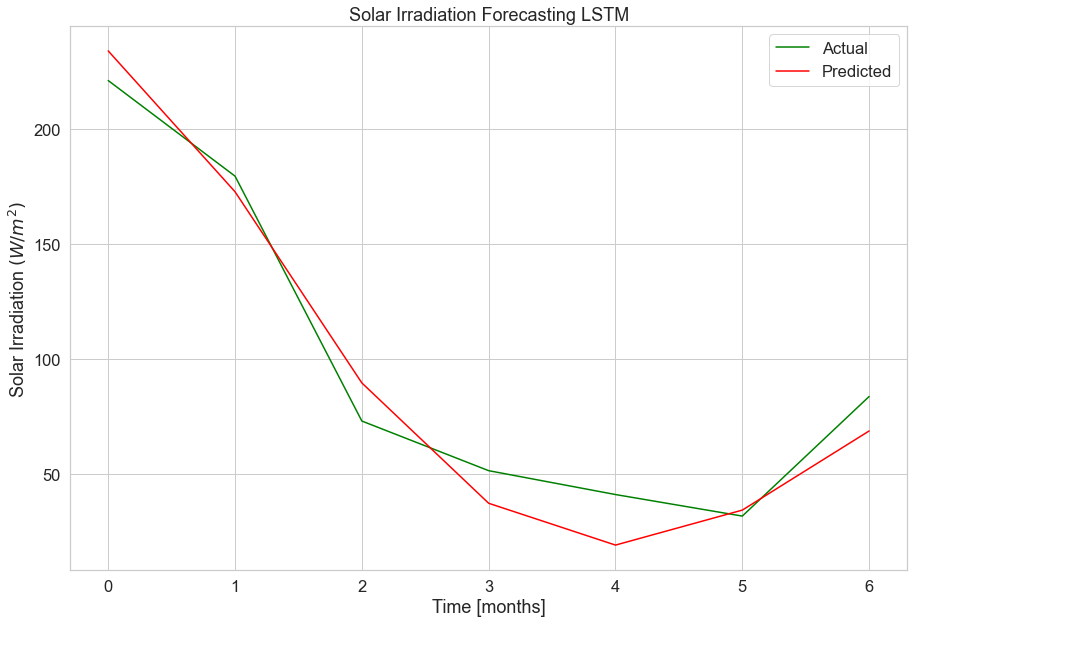

In [275]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(y_test_inverse, label="Actual", color='green')
plt.plot(y_hat_inverse, label="Predicted", color='red')
plt.annotate('Score: 92%', xy=(7.5, 4),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))
plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [months]')
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

In [265]:
from sklearn.metrics import r2_score

r2_score(y_test_inverse,y_hat_inverse)

0.9567529516521882

In [266]:
rms = mean_squared_error(y_test_inverse,y_hat_inverse, squared=False)
rms

14.141245944316573

In [267]:
#Plot Error

In [268]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    #ax.plot(x, y, color=color)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

In [269]:
L=len(y_hat_inverse)
x = np.linspace(0, L,L)

In [270]:
y_hat_inverse[:,0].std()

74.42496

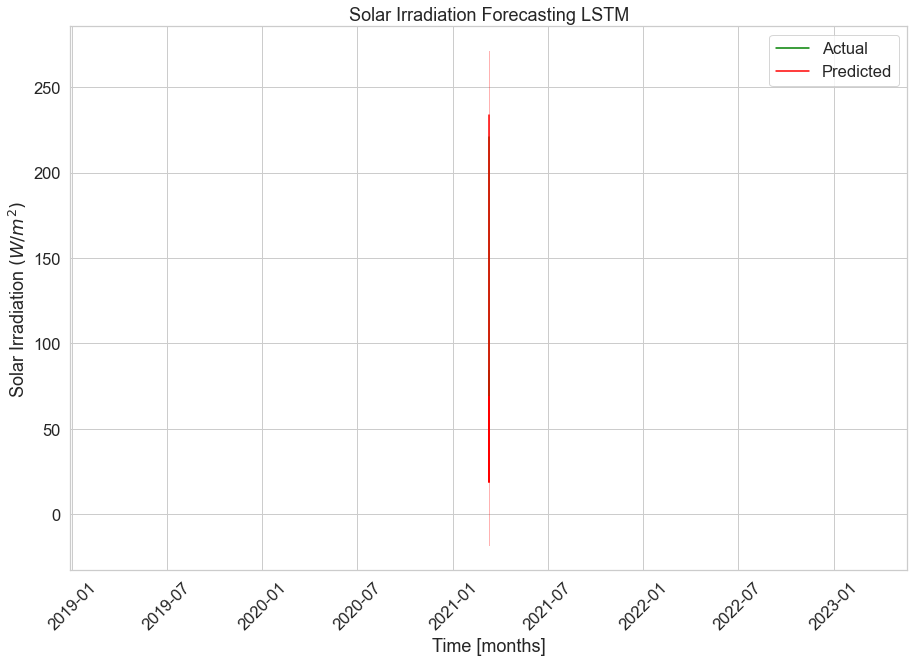

In [271]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(df2.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df2.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')
errorfill(df2.index[-len(X_test):],y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')

plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [months]')
plt.xticks(rotation=45)
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();

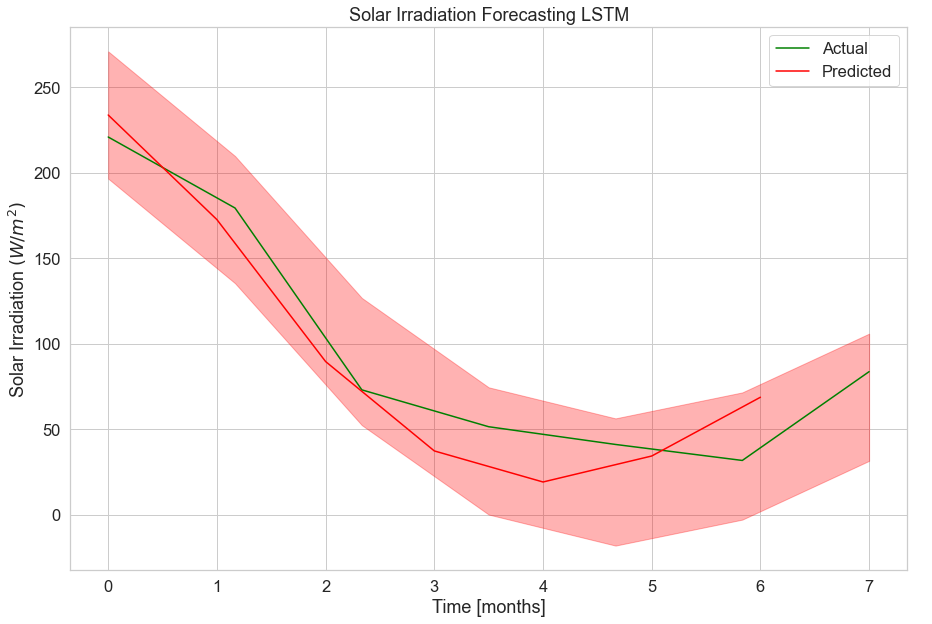

In [274]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(x,y_test_inverse, label="Actual", color='green')
plt.plot(y_hat_inverse, label="Predicted", color='red')
errorfill(x,y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')
plt.annotate('Score: 92%', xy=(7.5, 4),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))
plt.title('Solar Irradiation Forecasting LSTM')
plt.xlabel('Time [months]')
plt.ylabel(r'Solar Irradiation $(W/m^2)$')
plt.legend(loc='best')
 
plt.show();